In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 50 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Obj: 83.2537
0 -> 5 -> 3 -> 31 -> 42 -> 21 -> 13 -> 7 -> 18 -> 44 -> 36 -> 2 -> 27 -> 11 -> 47 -> 30 -> 10 -> 25 -> 46 -> 19 -> 6 -> 14 -> 39 -> 26 -> 35 -> 33 -> 49 -> 8 -> 22 -> 9 -> 24 -> 15 -> 29 -> 48 -> 17 -> 34 -> 32 -> 4 -> 43 -> 45 -> 23 -> 20 -> 12 -> 41 -> 40 -> 28 -> 38 -> 1 -> 37 -> 16 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:52<00:00, 18.98it/s]


Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.57it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.49it/s]


In [6]:
# with binding constr
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:32<00:00,  4.70it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2) 

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-0.5, num_epochs+0.5)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 20
log_step = 1

In [11]:
import copy
import time
from tqdm import tqdm
from clipgrad import clipGrad

def pipeline(reg, optimizer, forward_func, loss_func, num_epochs, log_step,
             loader_train, loader_val, loader_test, seed=42, grad_clip=False):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # clip gradients
            if grad_clip:
                clipGrad(reg, threshold=1e-6)
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
    regret_log_trn.append(regret_trn)
    regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
    regret_log_val.append(regret_val)
    tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
               format(epoch, regret_trn*100, regret_val*100))
    # load best model
    reg.load_state_dict(best_model_state)
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

### Large Learning Rate 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

Num of cores: 8


In [14]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-1)

In [15]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, optimizer, forwardCAVE, ca_cos, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [01:03<?, ?it/s]

Epoch   0, Train Regret: 329.3519%, Val Regret: 337.8251%


Epoch    0, Loss:  -0.9987:   5%|██▋                                                   | 1/20 [04:06<58:28, 184.65s/it]

Epoch   1, Train Regret:  24.8975%, Val Regret:  31.6269%


Epoch    1, Loss:  -0.9995:  10%|█████▍                                                | 2/20 [05:55<42:15, 140.84s/it]

Epoch   2, Train Regret:  16.9064%, Val Regret:  23.9921%


Epoch    2, Loss:  -0.9995:  15%|████████                                              | 3/20 [07:47<35:52, 126.62s/it]

Epoch   3, Train Regret:  14.3854%, Val Regret:  20.0668%


Epoch    3, Loss:  -0.9998:  20%|██████████▊                                           | 4/20 [09:41<32:14, 120.91s/it]

Epoch   4, Train Regret:  13.0129%, Val Regret:  18.6321%


Epoch    4, Loss:  -0.9997:  25%|█████████████▌                                        | 5/20 [11:34<29:27, 117.85s/it]

Epoch   5, Train Regret:  11.9450%, Val Regret:  17.1419%


Epoch    5, Loss:  -0.9998:  30%|████████████████▏                                     | 6/20 [13:22<27:02, 115.90s/it]

Epoch   6, Train Regret:  11.6719%, Val Regret:  15.7406%


Epoch    6, Loss:  -0.9998:  35%|██████████████████▉                                   | 7/20 [15:16<24:56, 115.08s/it]

Epoch   7, Train Regret:  11.3950%, Val Regret:  17.1603%


Epoch    7, Loss:  -0.9999:  40%|█████████████████████▌                                | 8/20 [17:08<22:40, 113.34s/it]

Epoch   8, Train Regret:  10.9658%, Val Regret:  15.5436%


Epoch    8, Loss:  -0.9998:  45%|████████████████████████▎                             | 9/20 [18:55<20:37, 112.51s/it]

Epoch   9, Train Regret:  10.8905%, Val Regret:  15.7284%


Epoch    9, Loss:  -0.9998:  50%|██████████████████████████▌                          | 10/20 [20:46<18:27, 110.76s/it]

Epoch  10, Train Regret:  10.5449%, Val Regret:  15.1942%


Epoch   10, Loss:  -0.9999:  55%|█████████████████████████████▏                       | 11/20 [22:40<16:41, 111.30s/it]

Epoch  11, Train Regret:  10.4588%, Val Regret:  15.4273%


Epoch   11, Loss:  -0.9999:  60%|███████████████████████████████▊                     | 12/20 [24:32<14:53, 111.65s/it]

Epoch  12, Train Regret:  10.4474%, Val Regret:  14.9614%


Epoch   12, Loss:  -0.9998:  65%|██████████████████████████████████▍                  | 13/20 [26:27<13:05, 112.17s/it]

Epoch  13, Train Regret:  10.3725%, Val Regret:  15.0553%


Epoch   13, Loss:  -0.9999:  70%|█████████████████████████████████████                | 14/20 [28:16<11:21, 113.63s/it]

Epoch  14, Train Regret:  10.7163%, Val Regret:  15.0604%


Epoch   14, Loss:  -0.9999:  75%|███████████████████████████████████████▊             | 15/20 [30:16<09:22, 112.56s/it]

Epoch  15, Train Regret:  10.2246%, Val Regret:  16.4659%


Epoch   15, Loss:  -0.9999:  80%|██████████████████████████████████████████▍          | 16/20 [32:19<07:43, 115.89s/it]

Epoch  16, Train Regret:  10.4535%, Val Regret:  16.0073%


Epoch   16, Loss:  -0.9999:  85%|█████████████████████████████████████████████        | 17/20 [34:23<05:55, 118.42s/it]

Epoch  17, Train Regret:   9.9991%, Val Regret:  15.2897%


Epoch   17, Loss:  -0.9999:  90%|███████████████████████████████████████████████▋     | 18/20 [36:24<03:59, 119.82s/it]

Epoch  18, Train Regret:  10.0711%, Val Regret:  16.3813%


Epoch   18, Loss:  -0.9999:  95%|██████████████████████████████████████████████████▎  | 19/20 [38:27<02:00, 120.46s/it]

Epoch  19, Train Regret:  10.2902%, Val Regret:  17.3143%


Epoch   19, Loss:  -0.9999: 100%|█████████████████████████████████████████████████████| 20/20 [39:15<00:00, 117.80s/it]


Epoch  19, Train Regret:  10.3667%, Val Regret:  16.6226%

Evaluation:
Test Regret: 16.6170%
Training Elapsed Time: 1039.84 Sec


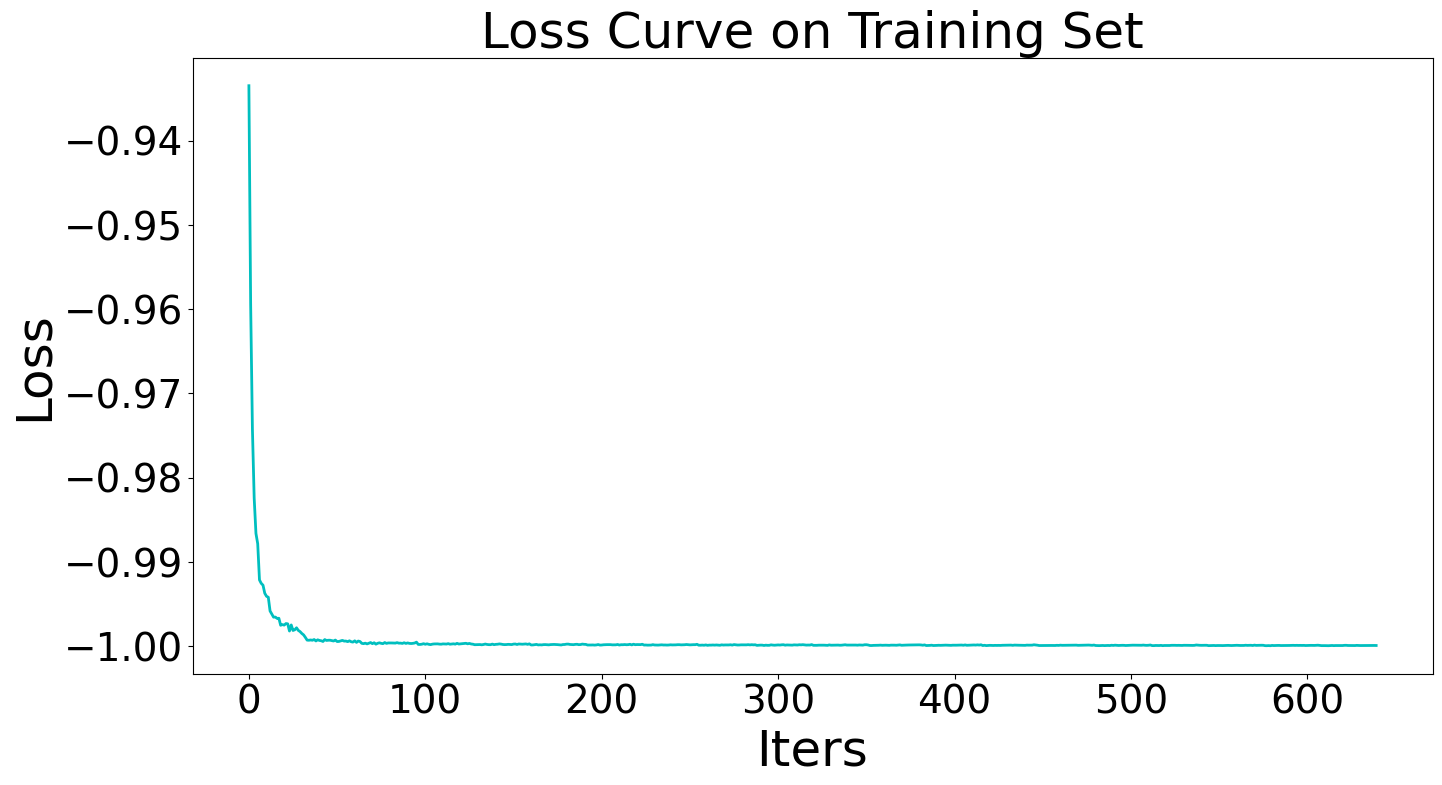

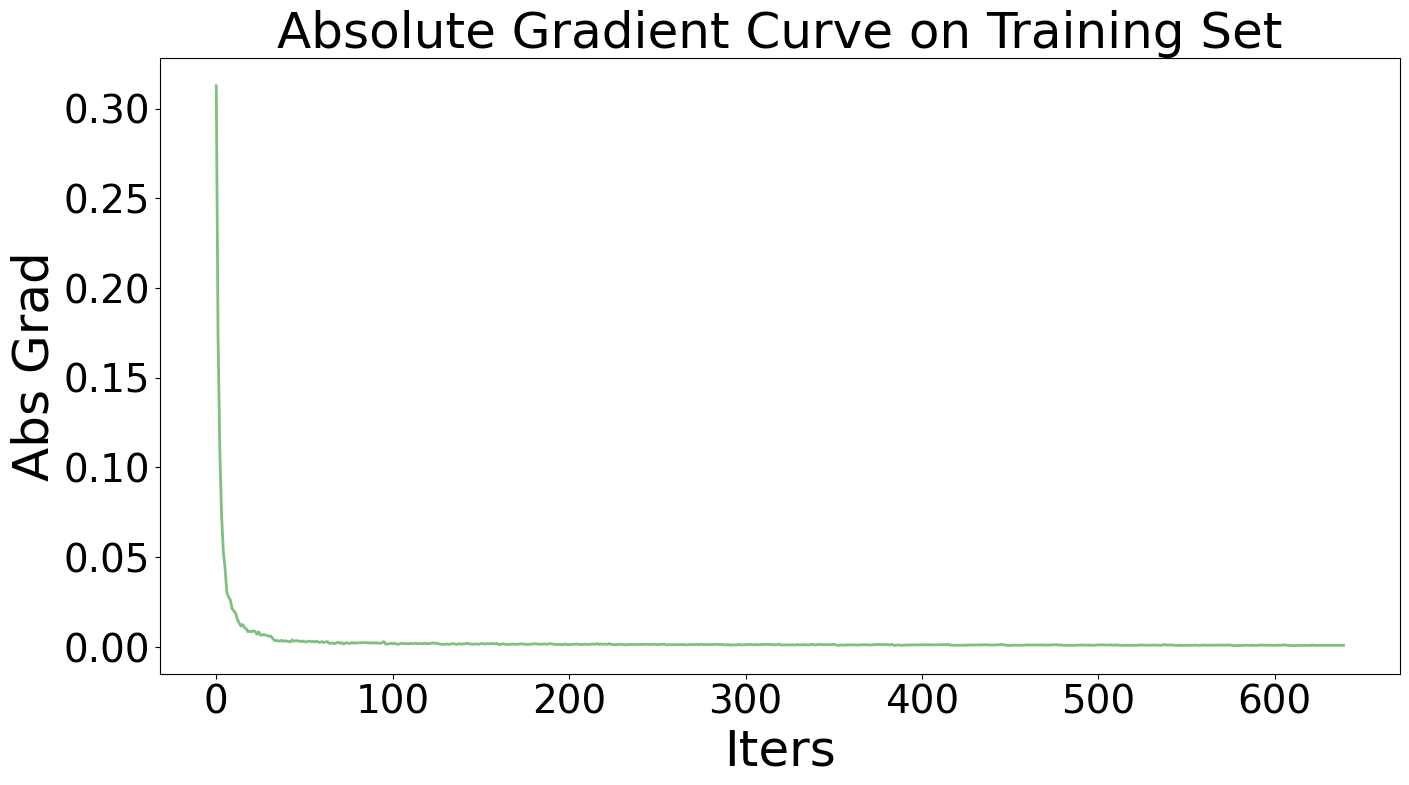

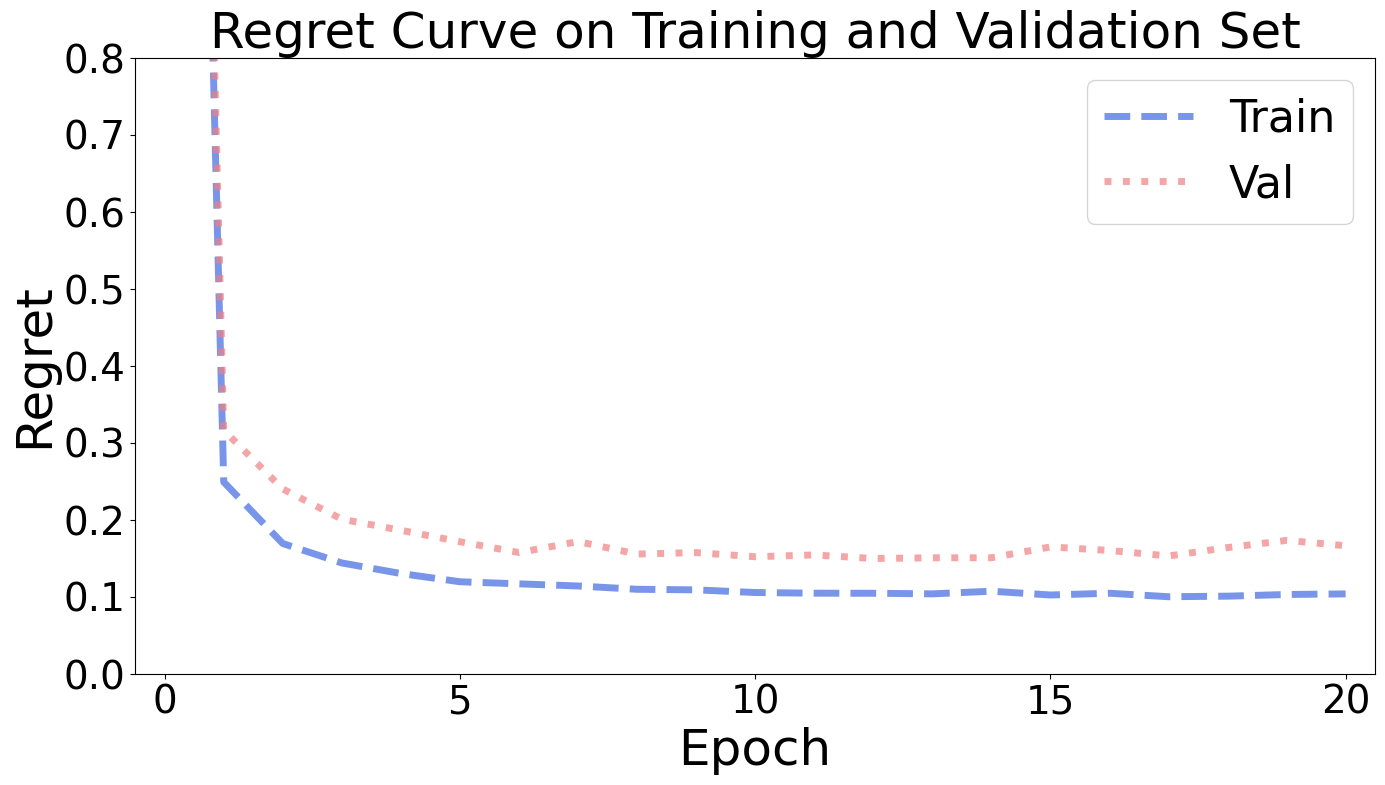

In [16]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

In [17]:
# change learning rate
for param_group in optimizer.param_groups:
            param_group["lr"] = 1e1

In [18]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, optimizer, forwardCAVE, ca_cos, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:58<?, ?it/s]

Epoch   0, Train Regret:  10.4437%, Val Regret:  14.9614%


Epoch    0, Loss:  -0.9974:   5%|██▋                                                   | 1/20 [02:49<33:20, 105.27s/it]

Epoch   1, Train Regret:  53.2705%, Val Regret:  62.9039%


Epoch    1, Loss:  -0.9992:  10%|█████▍                                                | 2/20 [04:31<32:20, 107.80s/it]

Epoch   2, Train Regret:  32.6388%, Val Regret:  41.2095%


Epoch    2, Loss:  -0.9987:  15%|████████                                              | 3/20 [06:23<30:00, 105.89s/it]

Epoch   3, Train Regret:  25.9702%, Val Regret:  32.6214%


Epoch    3, Loss:  -0.9997:  20%|██████████▊                                           | 4/20 [08:11<28:48, 108.02s/it]

Epoch   4, Train Regret:  21.9159%, Val Regret:  29.2969%


Epoch    4, Loss:  -0.9996:  25%|█████████████▌                                        | 5/20 [10:01<27:04, 108.28s/it]

Epoch   5, Train Regret:  19.9232%, Val Regret:  26.7897%


Epoch    5, Loss:  -0.9997:  30%|████████████████▏                                     | 6/20 [12:03<25:34, 109.59s/it]

Epoch   6, Train Regret:  17.9062%, Val Regret:  23.9241%


Epoch    6, Loss:  -0.9997:  35%|██████████████████▉                                   | 7/20 [13:51<24:19, 112.26s/it]

Epoch   7, Train Regret:  17.0313%, Val Regret:  22.8289%


Epoch    7, Loss:  -0.9999:  40%|█████████████████████▌                                | 8/20 [15:41<22:21, 111.75s/it]

Epoch   8, Train Regret:  16.2465%, Val Regret:  22.1514%


Epoch    8, Loss:  -0.9998:  45%|████████████████████████▎                             | 9/20 [17:35<20:21, 111.08s/it]

Epoch   9, Train Regret:  15.2013%, Val Regret:  21.1711%


Epoch    9, Loss:  -0.9998:  50%|██████████████████████████▌                          | 10/20 [19:24<18:38, 111.83s/it]

Epoch  10, Train Regret:  14.6138%, Val Regret:  20.4472%


Epoch   10, Loss:  -0.9998:  55%|█████████████████████████████▏                       | 11/20 [21:18<16:43, 111.49s/it]

Epoch  11, Train Regret:  14.2476%, Val Regret:  19.9839%


Epoch   11, Loss:  -0.9998:  60%|███████████████████████████████▊                     | 12/20 [23:04<14:54, 111.82s/it]

Epoch  12, Train Regret:  13.5918%, Val Regret:  19.9662%


Epoch   12, Loss:  -0.9998:  65%|██████████████████████████████████▍                  | 13/20 [24:59<12:53, 110.44s/it]

Epoch  13, Train Regret:  13.0498%, Val Regret:  17.8976%


Epoch   13, Loss:  -0.9998:  70%|█████████████████████████████████████                | 14/20 [26:51<11:05, 110.92s/it]

Epoch  14, Train Regret:  13.0288%, Val Regret:  18.2533%


Epoch   14, Loss:  -0.9998:  75%|███████████████████████████████████████▊             | 15/20 [28:46<09:18, 111.73s/it]

Epoch  15, Train Regret:  12.9071%, Val Regret:  18.3445%


Epoch   15, Loss:  -0.9999:  80%|██████████████████████████████████████████▍          | 16/20 [30:40<07:31, 112.94s/it]

Epoch  16, Train Regret:  12.6927%, Val Regret:  17.2437%


Epoch   16, Loss:  -0.9999:  85%|█████████████████████████████████████████████        | 17/20 [32:35<05:39, 113.04s/it]

Epoch  17, Train Regret:  12.1668%, Val Regret:  17.8457%


Epoch   17, Loss:  -0.9999:  90%|███████████████████████████████████████████████▋     | 18/20 [34:30<03:47, 113.51s/it]

Epoch  18, Train Regret:  12.2935%, Val Regret:  17.9598%


Epoch   18, Loss:  -0.9999:  95%|██████████████████████████████████████████████████▎  | 19/20 [36:24<01:54, 114.31s/it]

Epoch  19, Train Regret:  12.0068%, Val Regret:  16.7953%


Epoch   19, Loss:  -0.9997: 100%|█████████████████████████████████████████████████████| 20/20 [37:09<00:00, 111.47s/it]


Epoch  19, Train Regret:  12.0948%, Val Regret:  16.9571%

Evaluation:
Test Regret: 16.6170%
Training Elapsed Time: 915.88 Sec


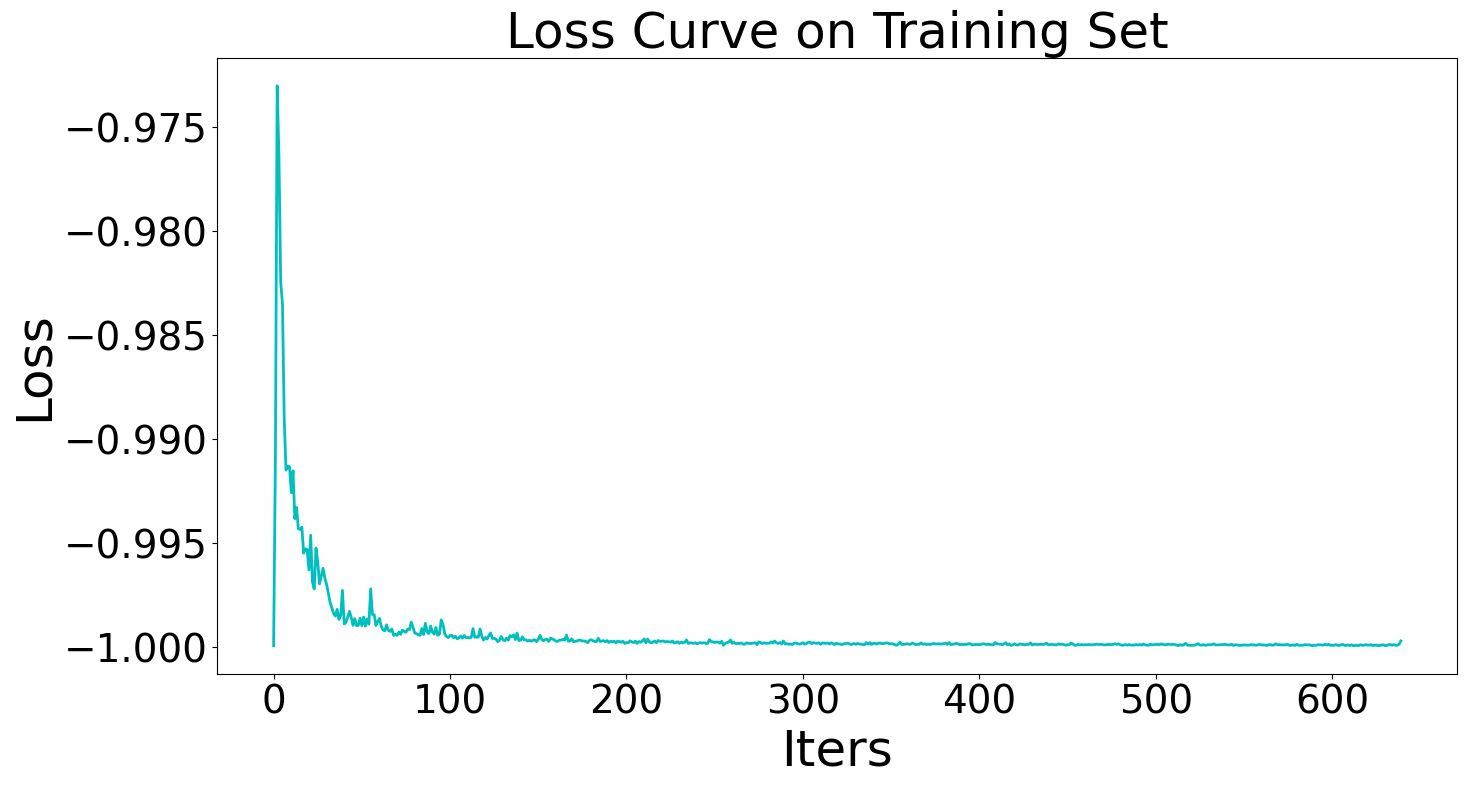

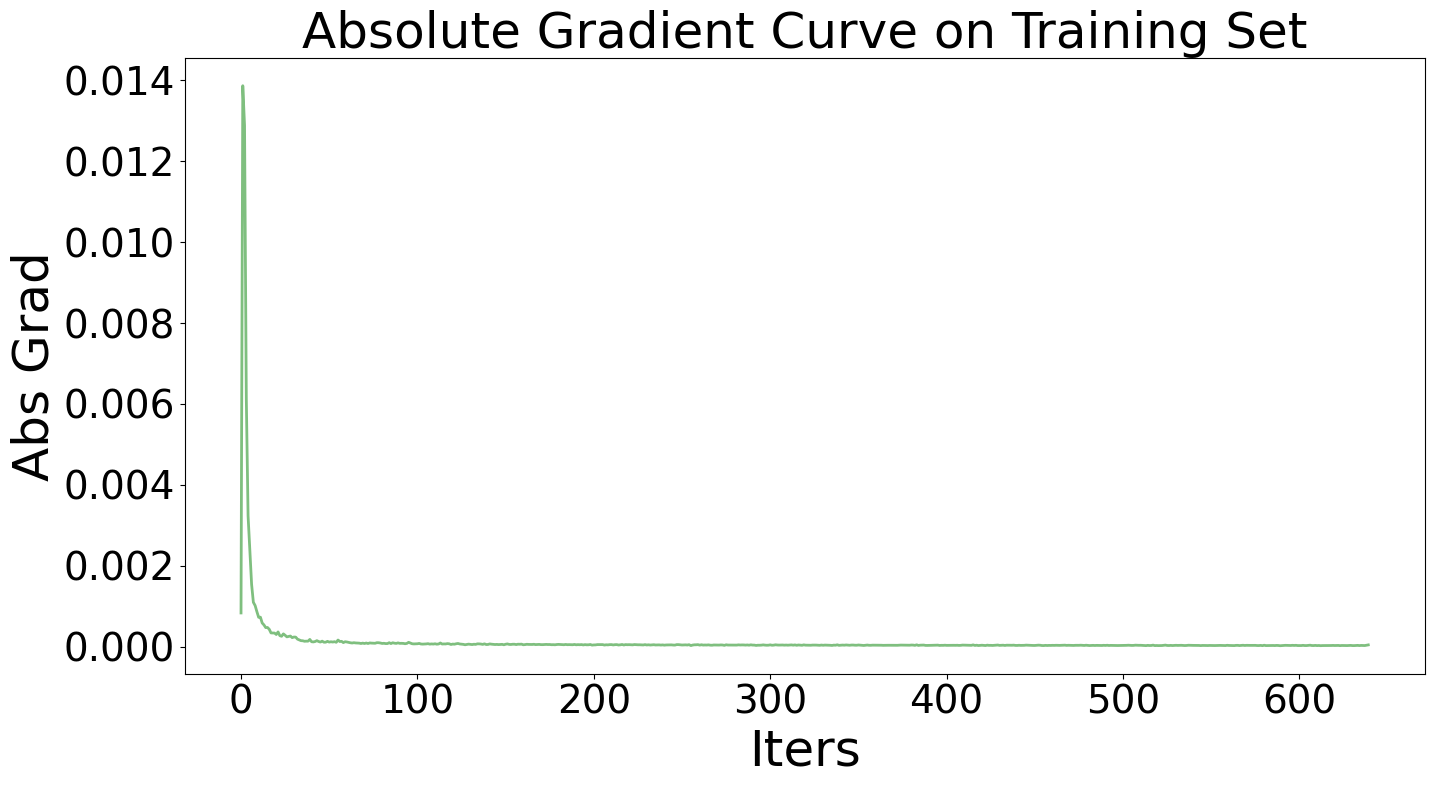

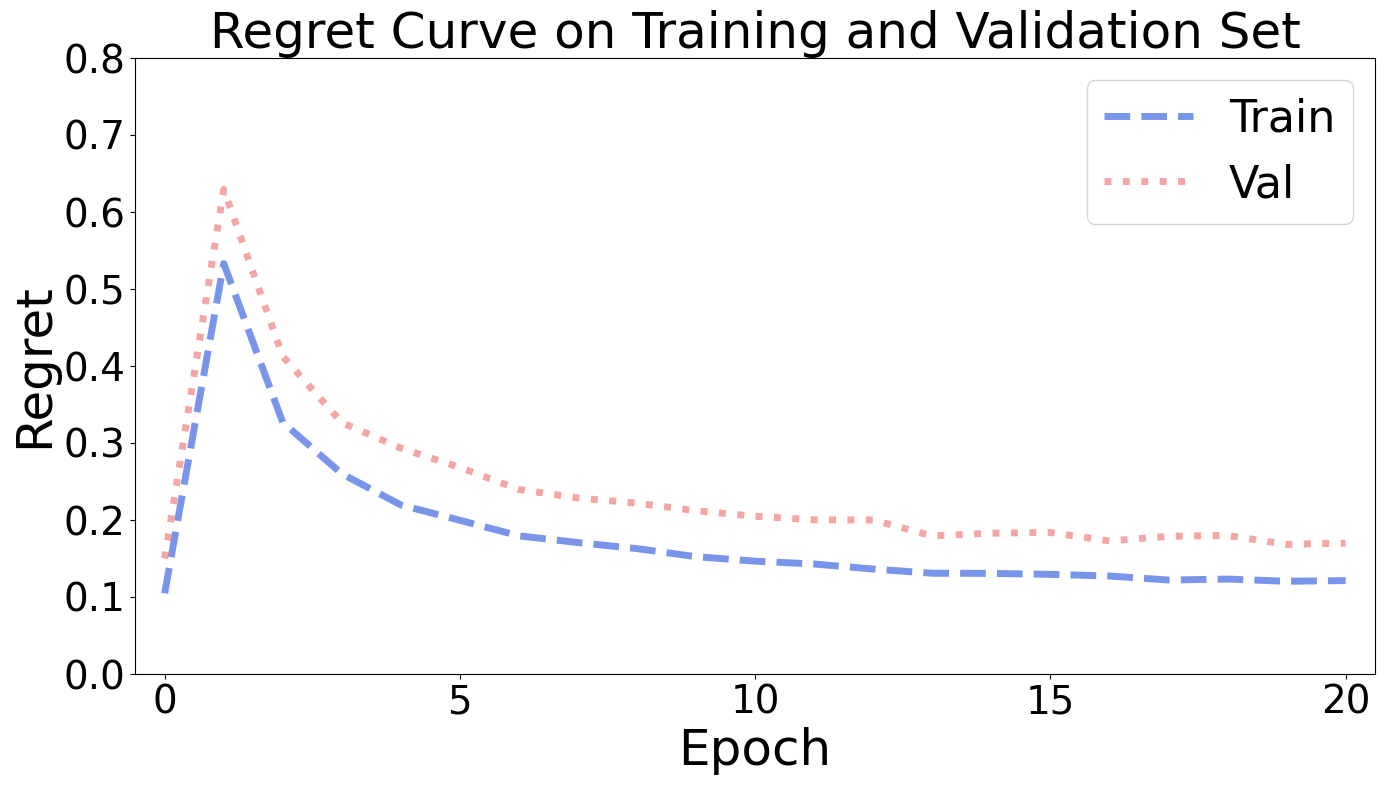

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Gradient Clip 

In [20]:
# init model
reg = LinearRegression()

In [21]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-1)

In [22]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, optimizer, forwardCAVE, ca_cos, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:57<?, ?it/s]

Epoch   0, Train Regret: 313.8339%, Val Regret: 318.3768%


Epoch    0, Loss:  -0.9986:   5%|██▋                                                   | 1/20 [02:38<31:48, 100.44s/it]

Epoch   1, Train Regret:  24.6887%, Val Regret:  28.0778%


Epoch    1, Loss:  -0.9995:  10%|█████▍                                                | 2/20 [04:29<30:33, 101.89s/it]

Epoch   2, Train Regret:  16.1662%, Val Regret:  19.4711%


Epoch    2, Loss:  -0.9996:  15%|████████                                              | 3/20 [06:21<30:03, 106.06s/it]

Epoch   3, Train Regret:  13.8182%, Val Regret:  18.2009%


Epoch    3, Loss:  -0.9998:  20%|██████████▊                                           | 4/20 [08:12<28:49, 108.08s/it]

Epoch   4, Train Regret:  12.7032%, Val Regret:  16.9666%


Epoch    4, Loss:  -0.9997:  25%|█████████████▌                                        | 5/20 [10:02<27:19, 109.32s/it]

Epoch   5, Train Regret:  12.0356%, Val Regret:  16.2108%


Epoch    5, Loss:  -0.9998:  30%|████████████████▏                                     | 6/20 [11:53<25:30, 109.33s/it]

Epoch   6, Train Regret:  11.6375%, Val Regret:  16.1315%


Epoch    6, Loss:  -0.9998:  35%|██████████████████▉                                   | 7/20 [13:43<23:47, 109.82s/it]

Epoch   7, Train Regret:  11.1254%, Val Regret:  16.5162%


Epoch    7, Loss:  -0.9999:  40%|█████████████████████▌                                | 8/20 [15:35<22:11, 110.93s/it]

Epoch   8, Train Regret:  10.9491%, Val Regret:  14.6942%


Epoch    8, Loss:  -0.9998:  45%|████████████████████████▎                             | 9/20 [17:28<20:27, 111.62s/it]

Epoch   9, Train Regret:  10.5815%, Val Regret:  16.0146%


Epoch    9, Loss:  -0.9998:  50%|██████████████████████████▌                          | 10/20 [19:21<18:32, 111.29s/it]

Epoch  10, Train Regret:  10.5210%, Val Regret:  16.0641%


Epoch   10, Loss:  -0.9999:  55%|█████████████████████████████▏                       | 11/20 [21:12<16:44, 111.60s/it]

Epoch  11, Train Regret:  10.6957%, Val Regret:  16.8945%


Epoch   11, Loss:  -0.9999:  60%|███████████████████████████████▊                     | 12/20 [23:06<14:55, 111.92s/it]

Epoch  12, Train Regret:  10.4884%, Val Regret:  16.0045%


Epoch   12, Loss:  -0.9998:  65%|██████████████████████████████████▍                  | 13/20 [24:55<13:06, 112.42s/it]

Epoch  13, Train Regret:  10.5699%, Val Regret:  17.8413%


Epoch   13, Loss:  -0.9999:  70%|█████████████████████████████████████                | 14/20 [26:44<11:05, 110.96s/it]

Epoch  14, Train Regret:  10.5445%, Val Regret:  16.8546%


Epoch   14, Loss:  -0.9999:  75%|███████████████████████████████████████▊             | 15/20 [28:33<09:13, 110.62s/it]

Epoch  15, Train Regret:  10.2266%, Val Regret:  17.1453%


Epoch   15, Loss:  -0.9999:  80%|██████████████████████████████████████████▍          | 16/20 [30:26<07:23, 110.84s/it]

Epoch  16, Train Regret:  10.2439%, Val Regret:  18.4410%


Epoch   16, Loss:  -0.9999:  85%|█████████████████████████████████████████████        | 17/20 [32:16<05:31, 110.64s/it]

Epoch  17, Train Regret:  10.0656%, Val Regret:  17.3994%


Epoch   17, Loss:  -0.9999:  90%|███████████████████████████████████████████████▋     | 18/20 [34:07<03:40, 110.49s/it]

Epoch  18, Train Regret:  10.3073%, Val Regret:  17.8676%


Epoch   18, Loss:  -0.9999:  95%|██████████████████████████████████████████████████▎  | 19/20 [35:49<01:49, 109.91s/it]

Epoch  19, Train Regret:  10.1613%, Val Regret:  18.0779%


Epoch   19, Loss:  -0.9999: 100%|█████████████████████████████████████████████████████| 20/20 [36:33<00:00, 109.70s/it]


Epoch  19, Train Regret:   9.9064%, Val Regret:  18.5674%

Evaluation:
Test Regret: 15.3771%
Training Elapsed Time: 882.41 Sec


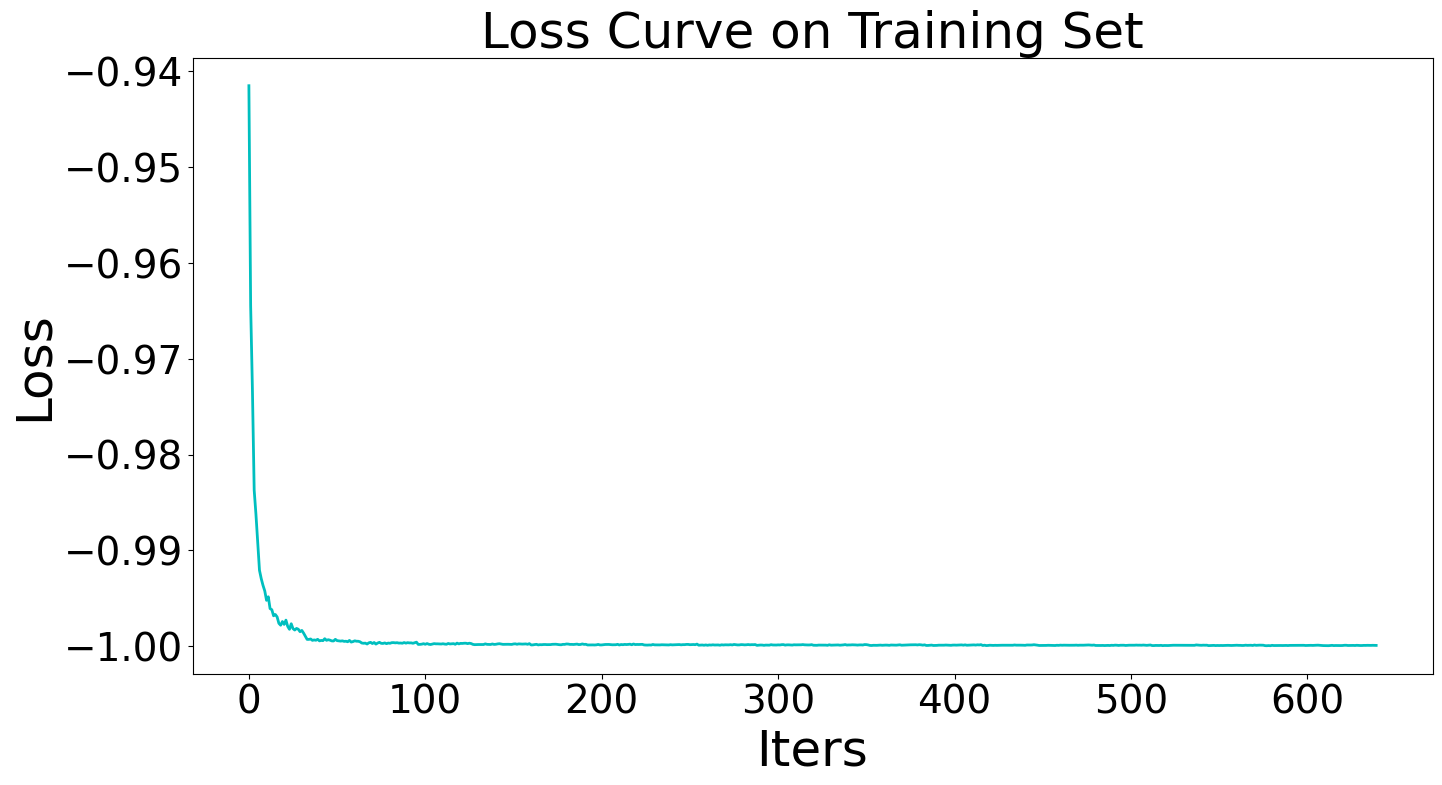

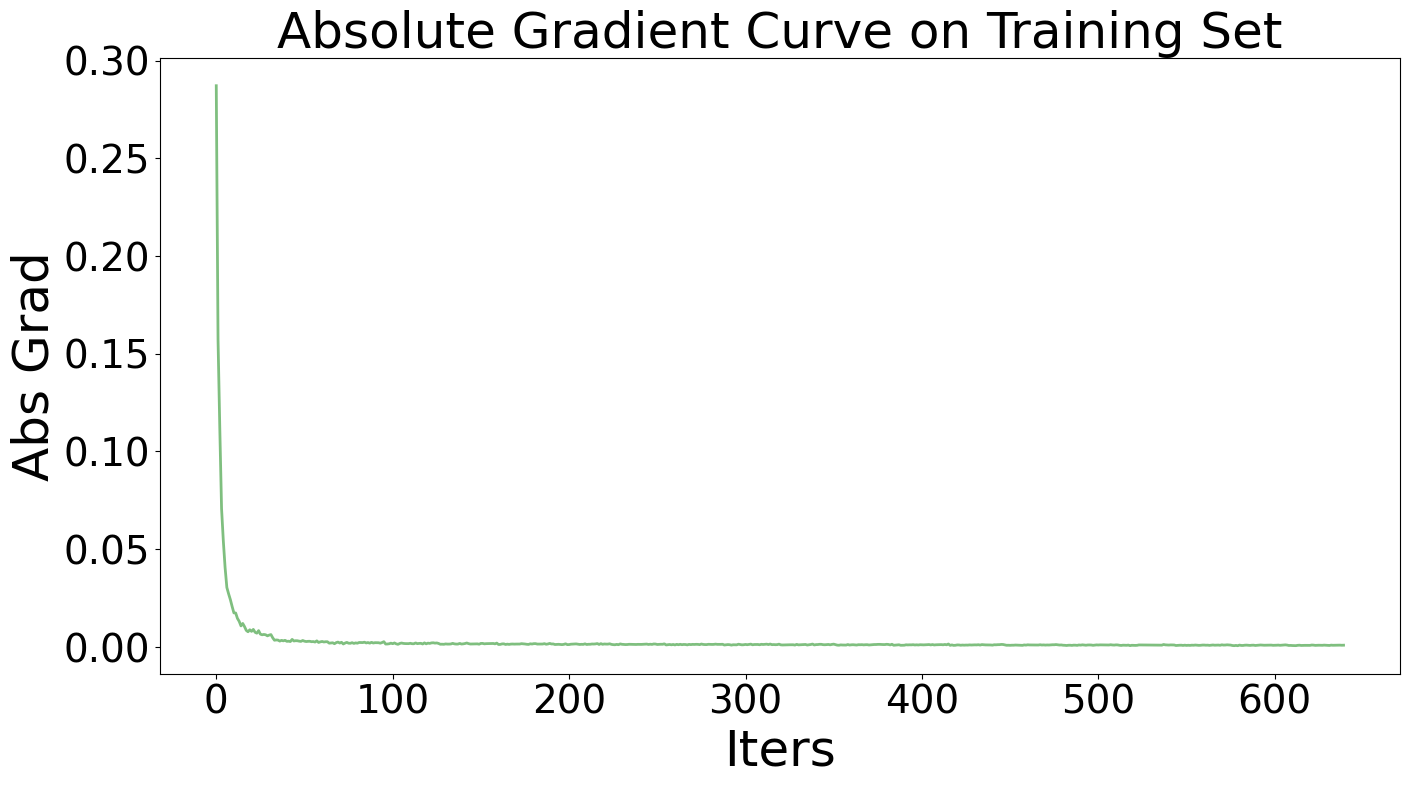

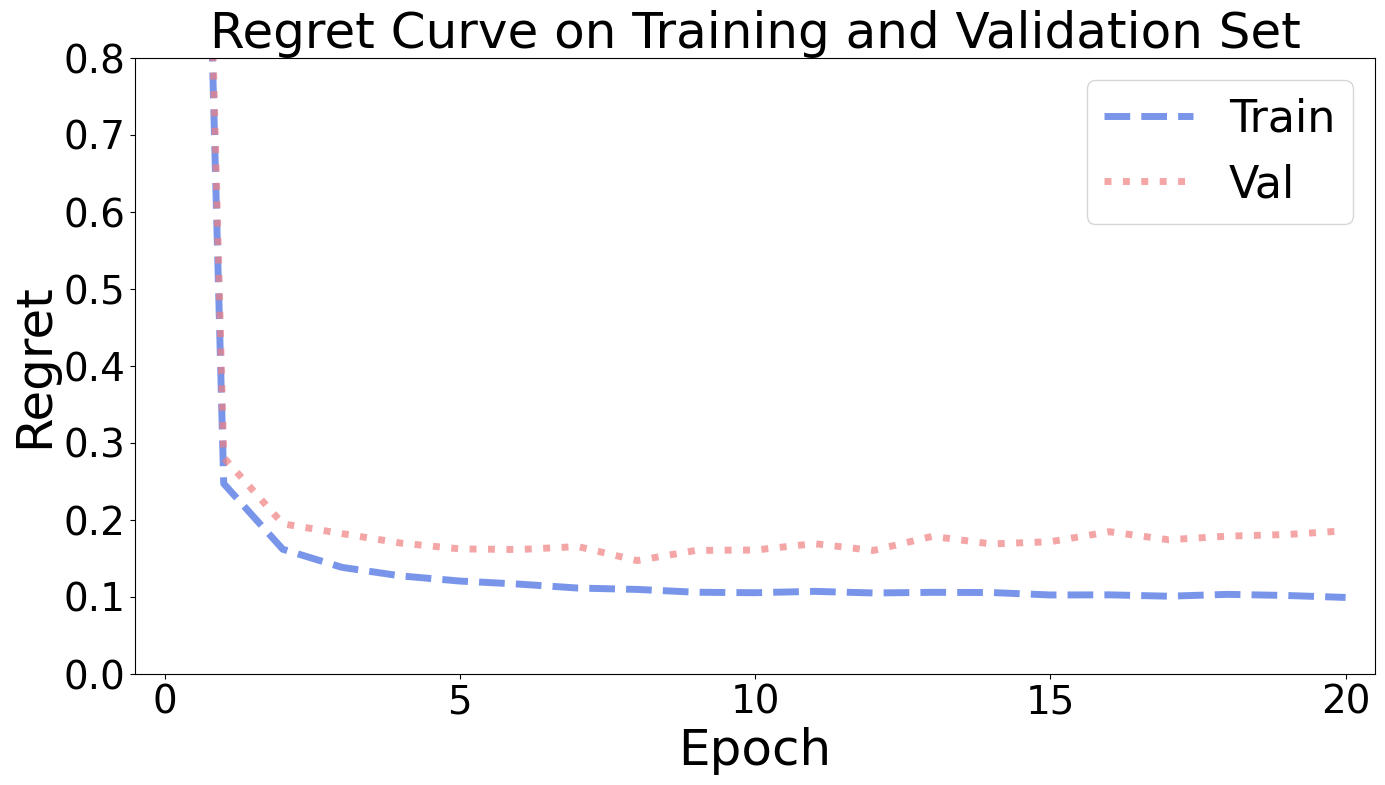

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

In [24]:
# change learning rate
for param_group in optimizer.param_groups:
            param_group["lr"] = 1e1

In [25]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, optimizer, forwardCAVE, ca_cos, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:57<?, ?it/s]

Epoch   0, Train Regret:  10.9390%, Val Regret:  14.6942%


Epoch    0, Loss:  -0.9970:   5%|██▋                                                   | 1/20 [02:42<32:11, 101.65s/it]

Epoch   1, Train Regret:  58.4934%, Val Regret:  66.6259%


Epoch    1, Loss:  -0.9991:  10%|█████▍                                                | 2/20 [04:23<31:00, 103.37s/it]

Epoch   2, Train Regret:  36.1197%, Val Regret:  46.0983%


Epoch    2, Loss:  -0.9989:  15%|████████                                              | 3/20 [06:13<28:55, 102.10s/it]

Epoch   3, Train Regret:  28.1923%, Val Regret:  36.0180%


Epoch    3, Loss:  -0.9996:  20%|██████████▊                                           | 4/20 [08:05<28:11, 105.73s/it]

Epoch   4, Train Regret:  23.9500%, Val Regret:  30.1823%


Epoch    4, Loss:  -0.9995:  25%|█████████████▌                                        | 5/20 [09:57<26:58, 107.92s/it]

Epoch   5, Train Regret:  20.9710%, Val Regret:  28.0344%


Epoch    5, Loss:  -0.9997:  30%|████████████████▏                                     | 6/20 [11:45<25:26, 109.07s/it]

Epoch   6, Train Regret:  19.2835%, Val Regret:  26.5325%


Epoch    6, Loss:  -0.9998:  35%|██████████████████▉                                   | 7/20 [13:37<23:39, 109.17s/it]

Epoch   7, Train Regret:  17.6332%, Val Regret:  24.6448%


Epoch    7, Loss:  -0.9998:  40%|█████████████████████▌                                | 8/20 [15:25<22:00, 110.03s/it]

Epoch   8, Train Regret:  16.5401%, Val Regret:  23.7822%


Epoch    8, Loss:  -0.9998:  45%|████████████████████████▎                             | 9/20 [17:12<19:58, 109.00s/it]

Epoch   9, Train Regret:  15.3563%, Val Regret:  23.6288%


Epoch    9, Loss:  -0.9998:  50%|██████████████████████████▌                          | 10/20 [19:00<18:04, 108.50s/it]

Epoch  10, Train Regret:  14.7466%, Val Regret:  22.7519%


Epoch   10, Loss:  -0.9998:  55%|█████████████████████████████▏                       | 11/20 [20:45<16:13, 108.15s/it]

Epoch  11, Train Regret:  14.3827%, Val Regret:  22.8230%


Epoch   11, Loss:  -0.9998:  60%|███████████████████████████████▊                     | 12/20 [22:30<14:16, 107.02s/it]

Epoch  12, Train Regret:  13.8841%, Val Regret:  22.4009%


Epoch   12, Loss:  -0.9998:  65%|██████████████████████████████████▍                  | 13/20 [24:17<12:27, 106.77s/it]

Epoch  13, Train Regret:  13.6404%, Val Regret:  21.0018%


Epoch   13, Loss:  -0.9999:  70%|█████████████████████████████████████                | 14/20 [26:03<10:40, 106.72s/it]

Epoch  14, Train Regret:  13.3329%, Val Regret:  19.8899%


Epoch   14, Loss:  -0.9998:  75%|███████████████████████████████████████▊             | 15/20 [27:45<08:50, 106.06s/it]

Epoch  15, Train Regret:  12.9243%, Val Regret:  19.2005%


Epoch   15, Loss:  -0.9998:  80%|██████████████████████████████████████████▍          | 16/20 [29:26<06:59, 105.00s/it]

Epoch  16, Train Regret:  12.6967%, Val Regret:  19.0021%


Epoch   16, Loss:  -0.9998:  85%|█████████████████████████████████████████████        | 17/20 [31:17<05:13, 104.39s/it]

Epoch  17, Train Regret:  12.5413%, Val Regret:  18.2514%


Epoch   17, Loss:  -0.9999:  90%|███████████████████████████████████████████████▋     | 18/20 [33:08<03:32, 106.49s/it]

Epoch  18, Train Regret:  12.1203%, Val Regret:  17.6541%


Epoch   18, Loss:  -0.9999:  95%|██████████████████████████████████████████████████▎  | 19/20 [34:55<01:47, 107.74s/it]

Epoch  19, Train Regret:  11.9600%, Val Regret:  17.1706%


Epoch   19, Loss:  -0.9995: 100%|█████████████████████████████████████████████████████| 20/20 [35:39<00:00, 106.96s/it]


Epoch  19, Train Regret:  11.7693%, Val Regret:  17.1897%

Evaluation:
Test Regret: 15.3771%
Training Elapsed Time: 859.25 Sec


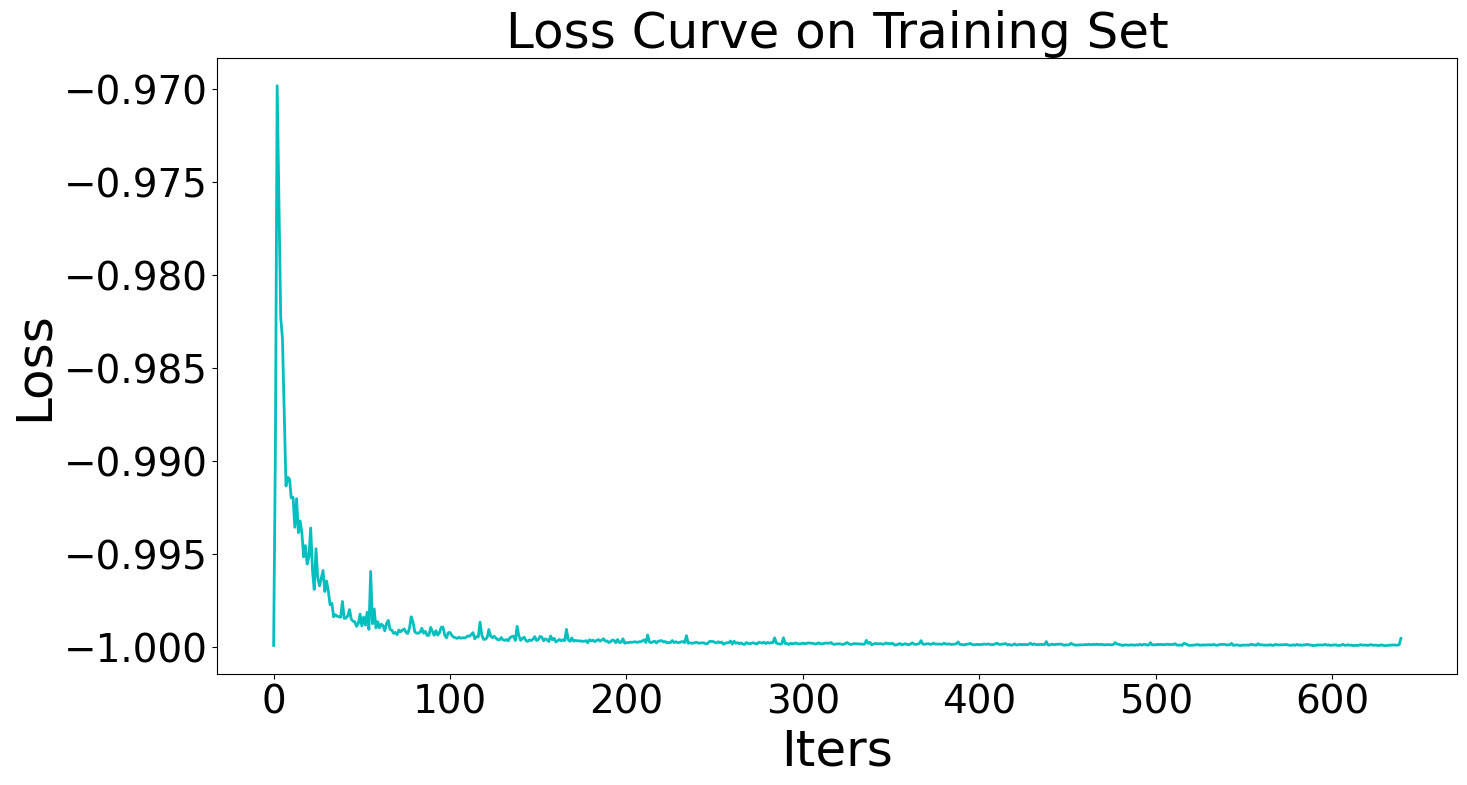

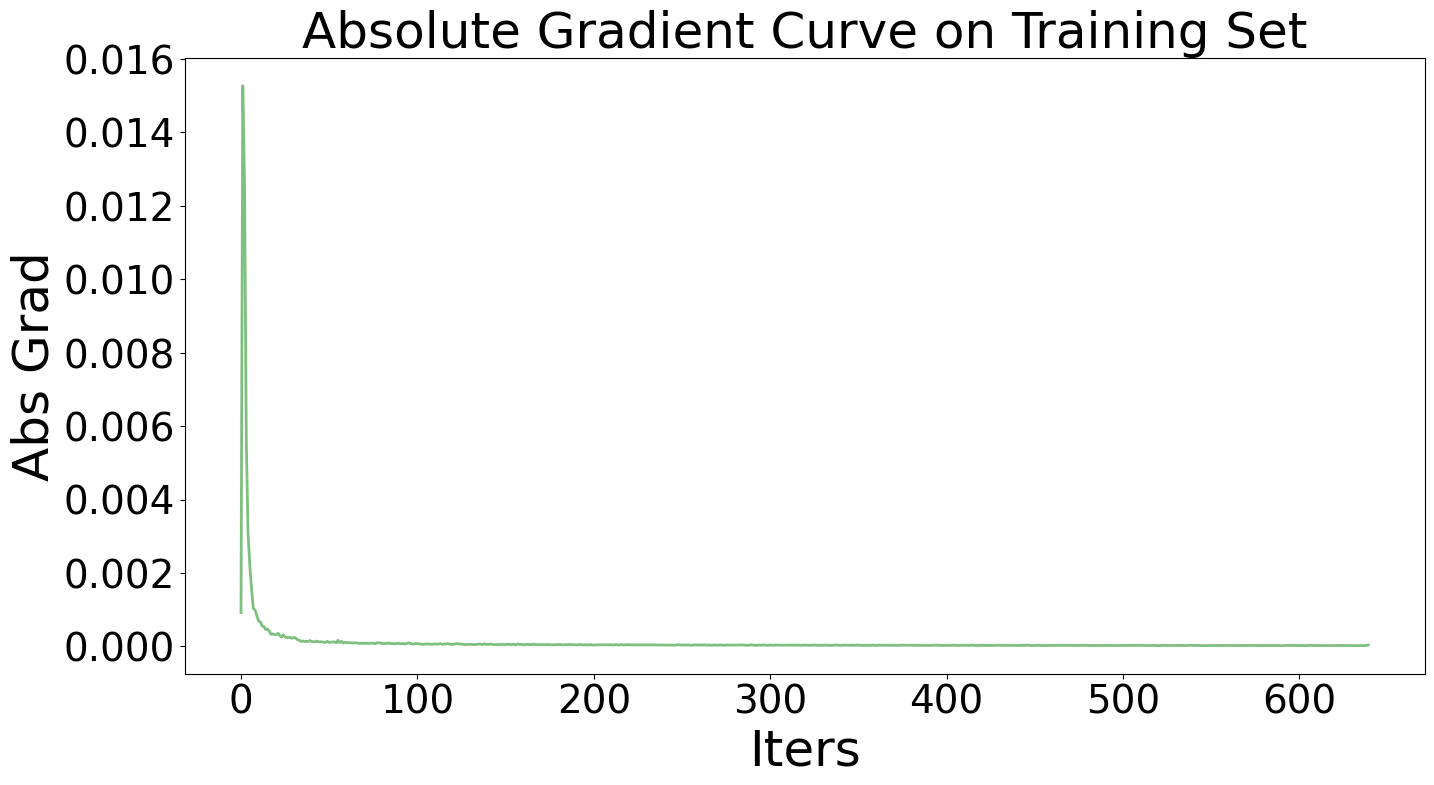

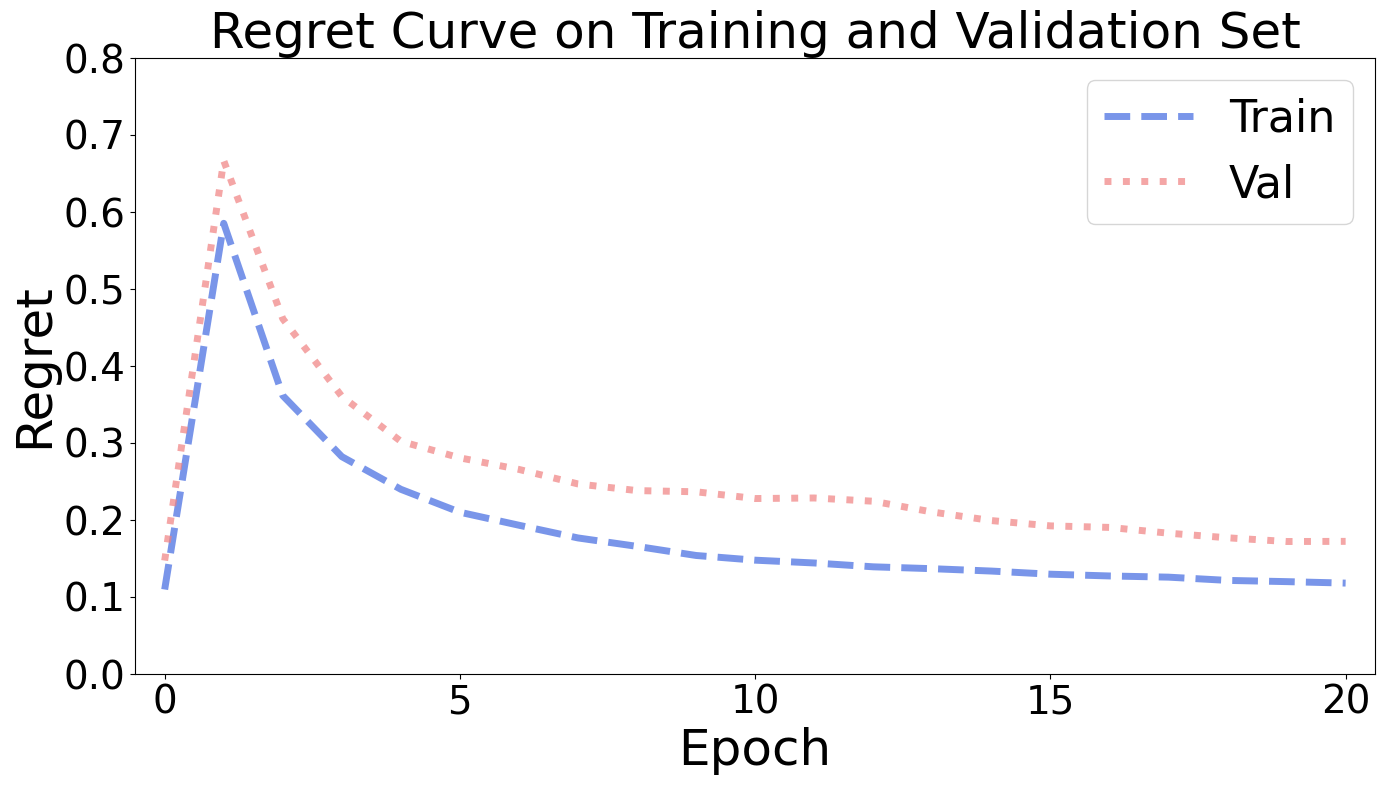

In [26]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)